In [49]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from webdriver_manager.chrome import ChromeDriverManager
from time import sleep
import time
#import re #정규식

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC #△3 :지연시간 대기를 위한 라이브러리

import matplotlib.pyplot as plt #그래프 라이브러리

import pymysql #파이썬에서 mysql을 다룰 수 있게 하는 라이브러리

from datetime import datetime #sql에 데이터를 넣을 떄, 현재 날짜를 알아야 한다.

import matplotlib.pyplot as plt #그래프를 그리기 위한 라이브러리
now = datetime.now()
day = int(now.strftime("%d")) + 1
now_date = now.strftime("%Y-%m-") + str(day) #△3 : 다음날 날짜값을 가져오기 위한 코드

db = pymysql.connect(host = 'localhost', port = 3306, user='root', passwd='pasword1357', db='blog_db', charset='utf8')
db_cursor = db.cursor() # DB 접속 및 커서 가져오는 코드


##여기까지가 환경설정 코드

In [39]:
class Weather_test: #클래스 인자로 웹드라이버와 지명을 받는다.
    def __init__(self, land_name="Seoul"):
        self.land_name = land_name
        self.bbc_precip_per_time = list()
        self.bbc_temp_per_time = list()
        self.kma_tomorrow_temp_list = list()
        self.kma_tomorrow_precip_list = list() 
        self.accu_tomorrow_temp_list = list()
        self.accu_tomorrow_precip_list = list()
        self.twc_tomorrow_temp_list = list()
        self.twc_tomorrow_precip_list = list()
    def bbc_weather(self):
        driver = webdriver.Chrome(ChromeDriverManager().install())
        driver.get("https://www.bbc.com/weather")
        #검색창에 도시명 검색
        elem = driver.find_element_by_class_name('ls-c-search__input') # 도시검색창을 지정하는 변수
        elem.clear()
        elem.send_keys(self.land_name)
        elem.send_keys(Keys.RETURN)
        waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "wr-time-slot-primary__hours")))
        #도시명 입력하고 난 후
        driver.execute_script("window.scrollTo(0, 200)")
        elem = driver.find_element_by_id("daylink-1") #다음날에 해당하는 태그 선택
        elem.click() #클릭

        every_time_content = driver.find_elements_by_class_name("wr-time-slot-primary__hours") #매 시간을 리스트로 받아온다.
        bbc_time = list()   
        for i in every_time_content:
            time = i.text
            bbc_time.append(time)
        every_temp = driver.find_elements_by_css_selector(".wr-temperature--time-slot > .wr-value--temperature--c")
        bbc_temp = list() #모든 온도를 받을 리스트
        for i in every_temp:
            temp = i.text.replace("°", "")
            bbc_temp.append(temp)
            
        every_PP = driver.find_elements_by_css_selector(".wr-time-slot-primary__precipitation > .wr-u-font-weight-500")
        bbc_precip = list() #모든 강수확률을 받을 리스트
        for i in every_PP:
            precip = i.text.replace("%", "")
            precip = precip.replace("chance of precipitation", "")
            precip = precip.replace('\n', '')
            bbc_precip.append(precip)

        self.bbc_temp_per_time = list() #(시간, 기온)형태의 리스트
        self.bbc_precip_per_time = list() # (시간, 강수확률) 형태의 리스트
        for i in zip(bbc_time, bbc_temp):
            self.bbc_temp_per_time.append(i)
            
        for i in zip(bbc_time, bbc_precip):
            self.bbc_precip_per_time.append(i)
       
        for i in range(0, 24):
            sql = "insert into weather_info values(\"" + str(now_date) + "\", \"" + self.land_name + "\", 'bbc',"+ str(self.bbc_temp_per_time[i][0]) + ", " + str(self.bbc_temp_per_time[i][1]) + ", " + str(self.bbc_precip_per_time[i][1]) + ");"
            db_cursor.execute(sql)
        db.commit() # DB에 저장하기 위한 코드
        print("DB에 저장 완료")

            
        print("BBC Weather 시간별 기온")
        print(self.bbc_temp_per_time)
        print("BBC Weather 시간별 강수확률")
        print(self.bbc_precip_per_time)
        driver.quit()
        
    def kma_weather(self):
        driver = webdriver.Chrome(ChromeDriverManager().install())
        driver.get("https://weather.naver.com/")
        sleep(1)
        search_button = driver.find_elements_by_css_selector("#header > div.gnb_area > div > div.button_group > button")
        search_button[0].click() #돋보기 버튼 클릭
        
        sleep(1.5)
        waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "_idSearchInput")))
        search_input = driver.find_elements_by_css_selector("#_idSearchInput")
        search_input[0].send_keys("서울")#
        sleep(1)
        search_city_name = driver.find_element_by_css_selector("#_idAutoCompleted > ul > li:nth-child(1) > a")
        search_city_name.click() #도시목록들 중, 첫번째 클릭

        kma_button = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.today_weather > div.cp_area > ul > li.item.kma > button")
        kma_button[0].click() #기상청 버튼 클릭

        waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "bb-texts"))) # UI가 다 나올때까지 대기
        driver.execute_script("window.scrollTo(0, 400)")

        kma_temp = list()
        kma_precip = list() #현재 시각부터 모레까지의 온도, 강수량, 시간이 들어간다.
        kma_time_list = list()

        kma_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
        kma_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
        for i, data in enumerate(kma_raw):
            if (i == 28):
                break;
            if (i % 2 == 0): 
                data_text = data.text.replace("시", "")
                kma_time_list.append(data_text)
            if (i % 2 == 1):
                data_text = data.text.replace("도", "")
                kma_temp.append(data_text)

        for i, data in enumerate(kma_precip_raw):
            if (i == 14):
                break;
            kma_precip.append(data.text)


        next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
        next_btn[0].click() #'다음'버튼 클릭 
        sleep(1.5)
        kma_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
        kma_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
        for i, data in enumerate(kma_raw):
            if (i < 28):
                pass
            elif (i == 56):
                break
            elif (i % 2 == 0): 
                data_text = data.text.replace("시", "")
                kma_time_list.append(data_text)
            elif (i % 2 == 1):
                data_text = data.text.replace("도", "")
                kma_temp.append(data_text)

        for i, data in enumerate(kma_precip_raw):
            if (i < 14):
                pass
            elif (i == 28):
                break
            else:
                kma_precip.append(data.text)


        next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
        next_btn[0].click() #'다음'버튼 클릭 
        sleep(2)
        kma_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
        kma_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
        for i, data in enumerate(kma_raw):
            if (i < 56):
                pass
            elif (i == 84):
                break
            elif (i % 2 == 0): 
                data_text = data.text.replace("시", "")
                kma_time_list.append(data_text)
                #print(i, data.text)
            elif (i % 2 == 1):
                data_text = data.text.replace("도", "")
                kma_temp.append(data_text)

        for i, data in enumerate(kma_precip_raw):
            if (i < 28):
                pass
            elif (i == 42):
                break
            else:
                kma_precip.append(data.text)

        #모인 데이터를 정확히 내일 날짜만 가공하기 위해 zip으로 모아줌
        kma_temp_data = zip(kma_time_list, kma_temp)
        kma_precip_data = zip(kma_time_list, kma_precip)

        switch = 0
        kma_today_list = list() #현재 이 시간부터 자정까지의 데이터가 들어 있다.
        self.kma_tomorrow_temp_list = list() # 최종 24시간짜리 아큐웨더의 기온 데이터가 들어있다.
        self.kma_tomorrow_precip_list = list() #강수확률 데이터
        for zipped_data in kma_temp_data:
            if (zipped_data[0] == '내일'):
                switch = 1
                #'내일'이라는 텍스를 '0시' 로 바꾸어준다
                list_for_tuple = list(zipped_data)
                list_for_tuple[0] = 0
                zipped_data = tuple(list_for_tuple) 
            if (zipped_data[0] == '모레'):
                switch = 0
            if (switch == 1):
                if (zipped_data[1] == ''):
                    list_for_tuple = list(zipped_data)
                    list_for_tuple[1] = 'NULL'
                    zipped_data = tuple(list_for_tuple)
                self.kma_tomorrow_temp_list.append(zipped_data)

        for zipped_data in kma_precip_data:
            if (zipped_data[0] == '내일'):
                switch = 1
                #'내일'이라는 텍스를 '0시' 로 바꾸어준다
                list_for_tuple = list(zipped_data)
                list_for_tuple[0] = 0
                zipped_data = tuple(list_for_tuple) 
            if (zipped_data[0] == '모레'):
                switch = 0
            if (switch == 1):
                if (zipped_data[1] == ''):
                    list_for_tuple = list(zipped_data)
                    list_for_tuple[1] = 'NULL'
                    zipped_data = tuple(list_for_tuple)
                self.kma_tomorrow_precip_list.append(zipped_data)
        print("내일 기상청 24시간 기온")
        print(self.kma_tomorrow_temp_list)
        print("내일 기상청 24시간 강수")
        print(self.kma_tomorrow_precip_list)
        driver.quit()
        
        for i in range(0, 24):
            sql = "insert into weather_info values(\"" + str(now_date) + "\", \"" + self.land_name + "\", 'kma',"+ str(self.kma_tomorrow_temp_list[i][0]) + ", " + str(self.kma_tomorrow_temp_list[i][1]) + ", " + str(self.kma_tomorrow_precip_list[i][1]) + ");"
            db_cursor.execute(sql)
        db.commit() # DB에 저장하기 위한 코드
        print("DB에 저장 완료")

        driver.quit()
    
    def accu_weather(self):
        driver = webdriver.Chrome(ChromeDriverManager().install())
        driver.get("https://weather.naver.com/")
        sleep(1)
        search_button = driver.find_elements_by_css_selector("#header > div.gnb_area > div > div.button_group > button")
        search_button[0].click() #돋보기 버튼 클릭
        
        sleep(1.5)
        waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "_idSearchInput")))
        search_input = driver.find_elements_by_css_selector("#_idSearchInput")
        search_input[0].send_keys("서울")#####
        sleep(1)
        search_city_name = driver.find_element_by_css_selector("#_idAutoCompleted > ul > li:nth-child(1) > a")
        search_city_name.click() #도시목록들 중, 첫번째 클릭

        accu_button = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.today_weather > div.cp_area > ul > li.item.accuweather > button")
        accu_button[0].click() #야큐웨더 버튼 클릭

        waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "bb-texts"))) # UI가 다 나올때까지 대기
        driver.execute_script("window.scrollTo(0, 400)")

        accu_temp = list()
        accu_precip = list() #현재 시각부터 모레까지의 온도, 강수량, 시간이 들어간다.
        accu_time_list = list()

        accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
        accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
        for i, data in enumerate(accu_raw):
            if (i == 28):
                break;
            if (i % 2 == 0): 
                data_text = data.text.replace("시", "")
                accu_time_list.append(data_text)
            if (i % 2 == 1):
                data_text = data.text.replace("도", "")
                accu_temp.append(data_text)

        for i, data in enumerate(accu_precip_raw):
            if (i == 14):
                break;
            accu_precip.append(data.text)


        next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
        next_btn[0].click() #'다음'버튼 클릭 
        sleep(1.5)
        accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
        accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
        for i, data in enumerate(accu_raw):
            if (i < 28):
                pass
            elif (i == 56):
                break
            elif (i % 2 == 0): 
                data_text = data.text.replace("시", "")
                accu_time_list.append(data_text)
            elif (i % 2 == 1):
                data_text = data.text.replace("도", "")
                accu_temp.append(data_text)

        for i, data in enumerate(accu_precip_raw):
            if (i < 14):
                pass
            elif (i == 28):
                break
            else:
                accu_precip.append(data.text)


        next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
        next_btn[0].click() #'다음'버튼 클릭 
        sleep(2)
        accu_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
        accu_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
        for i, data in enumerate(accu_raw):
            if (i < 56):
                pass
            elif (i == 84):
                break
            elif (i % 2 == 0): 
                data_text = data.text.replace("시", "")
                accu_time_list.append(data_text)
                #print(i, data.text)
            elif (i % 2 == 1):
                data_text = data.text.replace("도", "")
                accu_temp.append(data_text)

        for i, data in enumerate(accu_precip_raw):
            if (i < 28):
                pass
            elif (i == 42):
                break
            else:
                accu_precip.append(data.text)

        #모인 데이터를 정확히 내일 날짜만 가공하기 위해 zip으로 모아줌
        accu_temp_data = zip(accu_time_list, accu_temp)
        accu_precip_data = zip(accu_time_list, accu_precip)

        switch = 0
        accu_today_list = list() #현재 이 시간부터 자정까지의 데이터가 들어 있다.
        self.accu_tomorrow_temp_list = list() # 최종 24시간짜리 아큐웨더의 기온 데이터가 들어있다.
        self.accu_tomorrow_precip_list = list() #강수확률 데이터
        for zipped_data in accu_temp_data:
            if (zipped_data[0] == '내일'):
                switch = 1
                #'내일'이라는 텍스를 '0시' 로 바꾸어준다
                list_for_tuple = list(zipped_data)
                list_for_tuple[0] = 0
                zipped_data = tuple(list_for_tuple) 
            if (zipped_data[0] == '모레'):
                switch = 0
            if (switch == 1):
                if (zipped_data[1] == ''):
                    list_for_tuple = list(zipped_data)
                    list_for_tuple[1] = 'NULL'
                    zipped_data = tuple(list_for_tuple)
                self.accu_tomorrow_temp_list.append(zipped_data)

        for zipped_data in accu_precip_data:
            if (zipped_data[0] == '내일'):
                switch = 1
                #'내일'이라는 텍스를 '0시' 로 바꾸어준다
                list_for_tuple = list(zipped_data)
                list_for_tuple[0] = 0
                zipped_data = tuple(list_for_tuple) 
            if (zipped_data[0] == '모레'):
                switch = 0
            if (switch == 1):
                if (zipped_data[1] == ''):
                    list_for_tuple = list(zipped_data)
                    list_for_tuple[1] = 'NULL' #만약 비어있는 데이터가 있을 경우, NULL이라는 문자열로 대체->MySQL에 Insert 되게끔
                    zipped_data = tuple(list_for_tuple)
                self.accu_tomorrow_precip_list.append(zipped_data)
        print("내일 아큐웨더 24시간 기온")
        print(self.accu_tomorrow_temp_list)
        print("내일 아큐웨더 24시간 강수")
        print(self.accu_tomorrow_precip_list)
        driver.quit()
        
        for i in range(0, 24):
            sql = "insert into weather_info values(\"" + str(now_date) + "\", \"" + self.land_name + "\", 'accu',"+ str(self.accu_tomorrow_temp_list[i][0]) + ", " + str(self.accu_tomorrow_temp_list[i][1]) + ", " + str(self.accu_tomorrow_precip_list[i][1]) + ");"
            db_cursor.execute(sql)
        db.commit() # DB에 저장하기 위한 코드
        print("DB에 저장 완료")

        driver.quit()
    
    def twc_weather(self):
        driver = webdriver.Chrome(ChromeDriverManager().install())
        driver.get("https://weather.naver.com/")
        sleep(1)
        search_button = driver.find_elements_by_css_selector("#header > div.gnb_area > div > div.button_group > button")
        search_button[0].click() #돋보기 버튼 클릭
        
        sleep(1.5)
        waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, "_idSearchInput")))
        search_input = driver.find_elements_by_css_selector("#_idSearchInput")
        search_input[0].send_keys("서울")#
        sleep(1)
        search_city_name = driver.find_element_by_css_selector("#_idAutoCompleted > ul > li:nth-child(1) > a")
        search_city_name.click() #도시목록들 중, 첫번째 클릭

        twc_button = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.today_weather > div.cp_area > ul > li.item.twc > button")
        twc_button[0].click()# the weather channel 버튼 클릭

        waiting_for_result = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "bb-texts"))) # UI가 다 나올때까지 대기
        driver.execute_script("window.scrollTo(0, 400)")

        twc_temp = list()
        twc_precip = list() #현재 시각부터 모레까지의 온도, 강수량, 시간이 들어간다.
        twc_time_list = list()

        twc_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
        twc_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
        for i, data in enumerate(twc_raw):
            if (i == 28):
                break;
            if (i % 2 == 0): 
                data_text = data.text.replace("시", "")
                twc_time_list.append(data_text)
            if (i % 2 == 1):
                data_text = data.text.replace("도", "")
                twc_temp.append(data_text)

        for i, data in enumerate(twc_precip_raw):
            if (i == 14):
                break;
            twc_precip.append(data.text)


        next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
        next_btn[0].click() #'다음'버튼 클릭 
        sleep(1.5)
        twc_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
        twc_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
        for i, data in enumerate(twc_raw):
            if (i < 28):
                pass
            elif (i == 56):
                break
            elif (i % 2 == 0): 
                data_text = data.text.replace("시", "")
                twc_time_list.append(data_text)
            elif (i % 2 == 1):
                data_text = data.text.replace("도", "")
                twc_temp.append(data_text)

        for i, data in enumerate(twc_precip_raw):
            if (i < 14):
                pass
            elif (i == 28):
                break
            else:
                twc_precip.append(data.text)


        next_btn = driver.find_elements_by_css_selector("#content > div > div.section_center > div.card.card_today > div.time_weather > div.scroll_control.end_left._cnHourlyTmpr > button.btn_next")
        next_btn[0].click() #'다음'버튼 클릭 
        sleep(2)
        twc_raw = driver.find_elements_by_xpath("//*[@id='content']/div/div[1]/div[1]/div[2]/div[2]/div/div/ul/li/span")
        twc_precip_raw = driver.find_elements_by_css_selector("#hourly > div.inner_card.climate_rain > div > div > div > table > tbody > tr.row_icon > td > em")
        for i, data in enumerate(twc_raw):
            if (i < 56):
                pass
            elif (i == 84):
                break
            elif (i % 2 == 0): 
                data_text = data.text.replace("시", "")
                twc_time_list.append(data_text)
                #print(i, data.text)
            elif (i % 2 == 1):
                data_text = data.text.replace("도", "")
                twc_temp.append(data_text)

        for i, data in enumerate(twc_precip_raw):
            if (i < 28):
                pass
            elif (i == 42):
                break
            else:
                twc_precip.append(data.text)

        #모인 데이터를 정확히 내일 날짜만 가공하기 위해 zip으로 모아줌
        twc_temp_data = zip(twc_time_list, twc_temp)
        twc_precip_data = zip(twc_time_list, twc_precip)

        switch = 0
        twc_today_list = list() #현재 이 시간부터 자정까지의 데이터가 들어 있다.
        self.twc_tomorrow_temp_list = list() # 최종 24시간짜리 아큐웨더의 기온 데이터가 들어있다.
        self.twc_tomorrow_precip_list = list() #강수확률 데이터
        for zipped_data in twc_temp_data:
            if (zipped_data[0] == '내일'):
                switch = 1
                #'내일'이라는 텍스를 '0시' 로 바꾸어준다
                list_for_tuple = list(zipped_data)
                list_for_tuple[0] = 0
                zipped_data = tuple(list_for_tuple) 
            if (zipped_data[0] == '모레'):
                switch = 0
            if (switch == 1):
                if (zipped_data[1] == ''):
                    list_for_tuple = list(zipped_data)
                    list_for_tuple[1] = 'NULL'
                    zipped_data = tuple(list_for_tuple)
                self.twc_tomorrow_temp_list.append(zipped_data)

        for zipped_data in twc_precip_data:
            if (zipped_data[0] == '내일'):
                switch = 1
                #'내일'이라는 텍스를 '0시' 로 바꾸어준다
                list_for_tuple = list(zipped_data)
                list_for_tuple[0] = 0
                zipped_data = tuple(list_for_tuple) 
            if (zipped_data[0] == '모레'):
                switch = 0
            if (switch == 1):
                if (zipped_data[1] == ''):
                    list_for_tuple = list(zipped_data)
                    list_for_tuple[1] = 'NULL'
                    zipped_data = tuple(list_for_tuple)
                self.twc_tomorrow_precip_list.append(zipped_data)
        print("내일 weather channel 24시간 기온")
        print(self.twc_tomorrow_temp_list)
        print("내일 weather channel 24시간 강수")
        print(self.twc_tomorrow_precip_list)
        driver.quit()
        
        for i in range(0, 24):
            sql = "insert into weather_info values(\"" + str(now_date) + "\", \"" + self.land_name + "\", 'twc',"+ str(self.twc_tomorrow_temp_list[i][0]) + ", " + str(self.twc_tomorrow_temp_list[i][1]) + ", " + str(self.twc_tomorrow_precip_list[i][1]) + ");"
            db_cursor.execute(sql)
        db.commit() # DB에 저장하기 위한 코드
        print("DB에 저장 완료")
        driver.quit()


weather = Weather_test("Seoul")
weather.bbc_weather()
weather.accu_weather()
weather.kma_weather()
weather.twc_weather()



====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\tjdwn\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-39-9df14f242c35>:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
<ipython-input-39-9df14f242c35>:16: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  elem = driver.find_element_by_class_name('ls-c-search__input') # 도시검색창을 지정하는 변수
<ipython-input-39-9df14f242c35>:23: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_element() instead
  elem = driver.find_element_by_id("daylink-1") #다음날에 해당하는 태그 선택
<ipython-input-39-9df14f242c35>:26: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  every_time_content = drive

BBC Weather 시간별 기온
[('06', '-12'), ('07', '-12'), ('08', '-11'), ('09', '-9'), ('10', '-8'), ('11', '-6'), ('12', '-5'), ('13', '-4'), ('14', '-4'), ('15', '-4'), ('16', '-4'), ('17', '-4'), ('18', '-4'), ('19', '-5'), ('20', '-5'), ('21', '-6'), ('22', '-6'), ('23', '-7'), ('00', '-7'), ('01', '-8'), ('02', '-8'), ('03', '-8'), ('04', '-9'), ('05', '-9')]
BBC Weather 시간별 강수확률
[('06', '10'), ('07', '13'), ('08', '16'), ('09', '16'), ('10', '10'), ('11', '3'), ('12', '0'), ('13', '0'), ('14', '2'), ('15', '4'), ('16', '5'), ('17', '5'), ('18', '5'), ('19', '6'), ('20', '7'), ('21', '9'), ('22', '16'), ('23', '28'), ('00', '35'), ('01', '34'), ('02', '31'), ('03', '32'), ('04', '33'), ('05', '33')]




====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\tjdwn\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-39-9df14f242c35>:211: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
<ipython-input-39-9df14f242c35>:214: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  search_button = driver.find_elements_by_css_selector("#header > div.gnb_area > div > div.button_group > button")
<ipython-input-39-9df14f242c35>:219: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  search_input = driver.find_elements_by_css_selector("#_idSearchInput")
<ipython-input-39-9df14f242c35>:222: DeprecationWarning: find_element_by_* commands are deprecated. Please use find

내일 아큐웨더 24시간 기온
[(0, '-8'), ('1', '-8'), ('2', '-8'), ('3', '-8'), ('4', '-9'), ('5', '-9'), ('6', '-9'), ('7', '-10'), ('8', '-9'), ('9', '-8'), ('10', '-6'), ('11', '-4'), ('12', '-3'), ('13', '-2'), ('14', '-1'), ('15', '-1'), ('16', '-1'), ('17', '-2'), ('18', '-3'), ('19', '-4'), ('20', '-5'), ('21', '-6'), ('22', '-6'), ('23', 'NULL')]
내일 아큐웨더 24시간 강수
[(0, '0'), ('1', '0'), ('2', '0'), ('3', '0'), ('4', '0'), ('5', '0'), ('6', '0'), ('7', '0'), ('8', '0'), ('9', '0'), ('10', '0'), ('11', '0'), ('12', '0'), ('13', '0'), ('14', '0'), ('15', '0'), ('16', '0'), ('17', '0'), ('18', '0'), ('19', '0'), ('20', '0'), ('21', '0'), ('22', '0'), ('23', 'NULL')]




====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\tjdwn\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-39-9df14f242c35>:65: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
<ipython-input-39-9df14f242c35>:68: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  search_button = driver.find_elements_by_css_selector("#header > div.gnb_area > div > div.button_group > button")
<ipython-input-39-9df14f242c35>:73: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  search_input = driver.find_elements_by_css_selector("#_idSearchInput")
<ipython-input-39-9df14f242c35>:76: DeprecationWarning: find_element_by_* commands are deprecated. Please use find_ele

내일 기상청 24시간 기온
[(0, '-8'), ('1', '-8'), ('2', '-9'), ('3', '-9'), ('4', '-10'), ('5', '-10'), ('6', '-10'), ('7', '-11'), ('8', '-11'), ('9', '-10'), ('10', '-8'), ('11', '-7'), ('12', '-5'), ('13', '-4'), ('14', '-4'), ('15', '-4'), ('16', '-4'), ('17', '-5'), ('18', '-6'), ('19', '-7'), ('20', '-7'), ('21', '-7'), ('22', '-7'), ('23', 'NULL')]
내일 기상청 24시간 강수
[(0, '0'), ('1', '0'), ('2', '0'), ('3', '0'), ('4', '0'), ('5', '0'), ('6', '0'), ('7', '0'), ('8', '0'), ('9', '0'), ('10', '0'), ('11', '20'), ('12', '20'), ('13', '20'), ('14', '20'), ('15', '0'), ('16', '0'), ('17', '0'), ('18', '0'), ('19', '0'), ('20', '20'), ('21', '0'), ('22', '0'), ('23', 'NULL')]




====== WebDriver manager ======
Current google-chrome version is 97.0.4692
Get LATEST chromedriver version for 97.0.4692 google-chrome
Driver [C:\Users\tjdwn\.wdm\drivers\chromedriver\win32\97.0.4692.71\chromedriver.exe] found in cache
<ipython-input-39-9df14f242c35>:357: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(ChromeDriverManager().install())
<ipython-input-39-9df14f242c35>:360: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  search_button = driver.find_elements_by_css_selector("#header > div.gnb_area > div > div.button_group > button")
<ipython-input-39-9df14f242c35>:365: DeprecationWarning: find_elements_by_* commands are deprecated. Please use find_elements() instead
  search_input = driver.find_elements_by_css_selector("#_idSearchInput")
<ipython-input-39-9df14f242c35>:368: DeprecationWarning: find_element_by_* commands are deprecated. Please use find

내일 weather channel 24시간 기온
[(0, '-9'), ('1', '-9'), ('2', '-9'), ('3', '-10'), ('4', '-10'), ('5', '-11'), ('6', '-11'), ('7', '-11'), ('8', '-11'), ('9', '-8'), ('10', '-6'), ('11', '-5'), ('12', '-4'), ('13', '-3'), ('14', '-3'), ('15', '-3'), ('16', '-3'), ('17', '-4'), ('18', '-5'), ('19', '-6'), ('20', '-7'), ('21', '-7'), ('22', '-7'), ('23', 'NULL')]
내일 weather channel 24시간 강수
[(0, '1'), ('1', '1'), ('2', '2'), ('3', '2'), ('4', '0'), ('5', '2'), ('6', '2'), ('7', '2'), ('8', '2'), ('9', '0'), ('10', '0'), ('11', '0'), ('12', '0'), ('13', '0'), ('14', '0'), ('15', '0'), ('16', '0'), ('17', '0'), ('18', '0'), ('19', '0'), ('20', '2'), ('21', '2'), ('22', '2'), ('23', 'NULL')]


In [10]:
now = datetime.now()
now_date = now.strftime("%Y-%m-%d")
print(now_date)


sql = "insert into weather_info values(\"" + str(now_date) + "\", 'Busan', 'bbc', 01, 10, 0);"

print(sql)

db_cursor.execute(sql)

sql_read = "select time_info, temp, precip from weather_info;"
db_cursor.execute(sql_read)
db_result = db_cursor.fetchall()
print(db_result)

db.commit()
db.close()
'''
sql 테이블 구조:
create table weather_info(
    date_info DATE,
    place_name char(10),
    site_name char(10),
    time_info int,
    temp int,
    precip int
    );'''

2022-01-26
insert into weather_info values("2022-01-26", 'Busan', 'bbc', 01, 10, 0);
((1, 10, 0), (1, 10, 0), (1, 10, 0), (1, 10, 0))


'\nsql 테이블 구조:\ncreate table weather_info(\n    date_info DATE,\n    place_name char(10),\n    site_name char(10),\n    time_info int,\n    temp int,\n    precip int\n    );'

In [7]:
class Test:
    def __init__(self, num=1):
        self.num = num
        self.result = num
    def calc(self):
        self.result = self.result + 10
    def print_result(self):
        print(self.result)
        
def test_schedule(Test):
    test = Test()
    test.calc()
    test.print_result()
    print("스케쥴 함수 테스트 실행 끝")

test_schedule(Test)

11
스케쥴 함수 테스트 실행 끝


In [43]:
land_name = "Seoul"
bbc_temp_per_time = [0,0]
bbc_precip_per_time = [1,1]
sql_accu = "select temp from weather_info where (date_info = \"" + now_date +"\") and (site_name = \"accu\") and (place_name = \"" + land_name + "\") order by time_info asc;"
print(sql)

select temp from weather_info where (date_info = "2022-02-04") and (site_name = "accu") and (place_name = "Seoul") order by time_info asc;


In [50]:
sql_accu = "select temp from weather_info where (date_info = \"" + now_date +"\") and (site_name = \"accu\") and (place_name = \"" + land_name + "\") order by time_info asc;"
sql_bbc = "select temp from weather_info where (date_info = \"" + now_date +"\") and (site_name = \"bbc\") and (place_name = \"" + land_name + "\") order by time_info asc;"
sql_kma = "select temp from weather_info where (date_info = \"" + now_date +"\") and (site_name = \"kma\") and (place_name = \"" + land_name + "\") order by time_info asc;"
sql_twc = "select temp from weather_info where (date_info = \"" + now_date +"\") and (site_name = \"twc\") and (place_name = \"" + land_name + "\") order by time_info asc;"

sql_accu_precip = "select precip from weather_info where (date_info = \"" + now_date +"\") and (site_name = \"accu\") and (place_name = \"" + land_name + "\") order by time_info asc;"
sql_bbc_precip = "select precip from weather_info where (date_info = \"" + now_date +"\") and (site_name = \"accu\") and (place_name = \"" + land_name + "\") order by time_info asc;"
sql_kma_precip = "select precip from weather_info where (date_info = \"" + now_date +"\") and (site_name = \"accu\") and (place_name = \"" + land_name + "\") order by time_info asc;"
sql_twc_precip = "select precip from weather_info where (date_info = \"" + now_date +"\") and (site_name = \"accu\") and (place_name = \"" + land_name + "\") order by time_info asc;"

accu_Seoul_temp = list()
accu_Seoul_precip = list()
bbc_Seoul_temp = list()
bbc_Seoul_precip = list()
kma_Seoul_temp = list()
kma_Seoul_precip = list()
twc_Seoul_temp = list()
twc_Seoul_precip = list()


db_cursor.execute(sql_accu)
db_result = db_cursor.fetchall()
for i in db_result:
    accu_Seoul_temp.append(i[0])
    
db_cursor.execute(sql_bbc)
db_result = db_cursor.fetchall()
for i in db_result:
    bbc_Seoul_temp.append(i[0])
    
db_cursor.execute(sql_kma)
db_result = db_cursor.fetchall()
for i in db_result:
    kma_Seoul_temp.append(i[0])

db_cursor.execute(sql_twc)
db_result = db_cursor.fetchall()
for i in db_result:
    twc_Seoul_temp.append(i[0])     #△4블록  : SQL에서 예상 기온 조회

    
db_cursor.execute(sql_accu_precip)
db_result = db_cursor.fetchall()
for i in db_result:
    accu_Seoul_precip.append(i[0])
    
db_cursor.execute(sql_bbc_precip)
db_result = db_cursor.fetchall()
for i in db_result:
    bbc_Seoul_precip.append(i[0])

db_cursor.execute(sql_twc_precip)
db_result = db_cursor.fetchall()
for i in db_result:
    twc_Seoul_precip.append(i[0])
    
db_cursor.execute(sql_kma_precip)
db_result = db_cursor.fetchall()
for i in db_result:
    kma_Seoul_precip.append(i[0])   #△4블록  : SQL에서 예상 강수량 조회
    
print(accu_Seoul_temp)
print(bbc_Seoul_temp)
print(kma_Seoul_temp)
print(twc_Seoul_temp)

print(accu_Seoul_precip)
print(bbc_Seoul_precip)
print(kma_Seoul_precip)
print(twc_Seoul_precip)


db.commit()
db_cursor.close()
db.close()

[-8, -8, -8, -8, -9, -9, -9, -10, -9, -8, -6, -4, -3, -2, -1, -1, -1, -2, -3, -4, -5, -6, -6, None]
[-7, -8, -8, -8, -9, -9, -12, -12, -11, -9, -8, -6, -5, -4, -4, -4, -4, -4, -4, -5, -5, -6, -6, -7]
[-8, -8, -9, -9, -10, -10, -10, -11, -11, -10, -8, -7, -5, -4, -4, -4, -4, -5, -6, -7, -7, -7, -7, None]
[-9, -9, -9, -10, -10, -11, -11, -11, -11, -8, -6, -5, -4, -3, -3, -3, -3, -4, -5, -6, -7, -7, -7, None]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None]


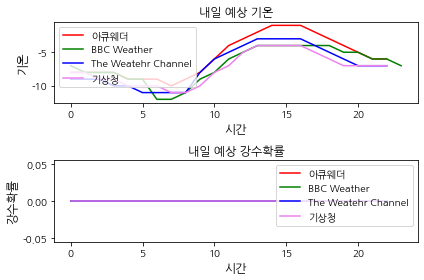

In [74]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23] #x축 범례(시간)

plt.rcParams['font.family'] = 'NanumGothic' #한글 폰트 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False # 음수(-) 기호 깨짐 방지

x1 = plt.subplot(2, 1, 1)         
plt.xlabel('시간', fontdict = {'size' : 'large'})
plt.ylabel('기온', fontdict = {'size' : 'large'})
plt.plot(x, accu_Seoul_temp, color = "r", label = "아큐웨더")
plt.plot(x, bbc_Seoul_temp, color = "g" , label = "BBC Weather")
plt.plot(x, twc_Seoul_temp, color = "b", label = "The Weatehr Channel")
plt.plot(x, kma_Seoul_temp, color = "violet", label = "기상청")
plt.title('내일 예상 기온')
plt.legend()

x2 = plt.subplot(2, 1, 2, sharex = x1)  
plt.xlabel('시간', fontdict = {'size' : 'large'})
plt.ylabel('강수확률', fontdict = {'size' : 'large'})
plt.plot(x, accu_Seoul_precip, color = "r", label = "아큐웨더")
plt.plot(x, bbc_Seoul_precip, color = "g" , label = "BBC Weather")
plt.plot(x, twc_Seoul_precip, color = "b", label = "The Weatehr Channel")
plt.plot(x, kma_Seoul_precip, color = "violet", label = "기상청")
plt.title('내일 예상 강수확률')
plt.legend()
plt.tight_layout()

plt.show()

In [47]:
db_cursor.close()

In [ ]:
plt.subplot(2, 1, 1)                # nrows=2, ncols=1, index=1
plt.plot(x1, y1, 'o-')
plt.title('1st Graph')
plt.ylabel('Damped oscillation')

plt.subplot(2, 1, 2)                # nrows=2, ncols=1, index=2
plt.plot(x2, y2, '.-')
plt.title('2nd Graph')
plt.xlabel('time (s)')
plt.ylabel('Undamped')